# PSI Checks
When you are doing an OTV project and your model is unstable, try checking your input variables.
This notebook performs checks by letting you add a grouping column (like Month) and iteratively compare a reference month to each subsequent month and will print out the offending month-variable combinations where the data is not stable by exceeding PSI of 0.25.

### Library Imports

In [2]:
### Standard Imports - Sorry PEP8 fans, do not look below
import pandas as pd, numpy as np, os, re, json, sys
from pathlib import Path
from datetime import datetime

from joshberry.utils import *
from joshberry.feats import *

## Specific Imports
from matplotlib import pyplot as plt
import matplotlib as mpl
import plotly.express as px
%timeit
%matplotlib inline

#### DataRobot API tokens (I save my API token as an environmental variable)
ENDPOINT_URL = "https://app.datarobot.com/api/v2"

if os.environ.get("DR_API_TOKEN") == None:
    API_TOKEN = "OR__pasteyourtokenherefromthedatarobotbyclickinginthetopright"
else:
    API_TOKEN = os.environ.get("DR_API_TOKEN")

### Display options for notebooks
pd_options = {'display.max_rows': 25,'display.max_columns': 500}
[pd.set_option(option, setting) for option, setting in pd_options.items()]

### set path directories
curr_dir = Path(os.getcwd())
data_dir = Path(curr_dir.parents[0] / 'data/')
artifacts_dir = Path(curr_dir.parents[0] / 'artifacts/')

print('Current Directory is: ', str(curr_dir))

Current Directory is:  /Users/josh.berry/_demos/notebooks/PSI Checks/notebooks


In [3]:
### Common project specific variables
FILENAME = 'kicked_train_OTP.csv'  # original data

GROUP_COL = 'yyyymm'
REF_VALUE = 'REF'
DATE_COL = 'PurchDate'

### Helper Functions

### Data Import

In [8]:
indata = pd.read_csv(Path(data_dir) / FILENAME, low_memory=False)

### Configure Group Column
All we want to do here is to create a GROUP_COL which identifies each "time slice" that we'll interate over to calculate PSI. 

Usually I will aggregete to a month, week, or day. 

Another thing I like to do is aggregate a longer time period (i.e training) into a single group that is used as my reference period.

In [9]:
# convert to a datetime
indata[DATE_COL] = pd.to_datetime(indata[DATE_COL])

# Two things going on here:
#    (1) format as YYYYMM to group by month
#    (2) add a specific value for my reference time period
indata[GROUP_COL] = np.where(indata[DATE_COL] < '2010-02-01'
                             , REF_VALUE
                             , indata[DATE_COL].dt.strftime('%Y%m')
                            )

# add a filter to exclude really old ones because I saw some weird data there
indata['exclude'] = np.where(indata[DATE_COL] > '2010-05-31'
                            , 1
                            , 0)

# exclude
indata = indata[indata['exclude']==0].copy()

## Helper Functions

In [10]:
#function to break numeric variables into bins (smaller bin number means more forgiving tolerance to shifts)
def calc_psi_nums(E,A,Var=1, TimeSliceIndex=1):
    
    N_BINS = 5
    
    # attempt to bin reference data with n bins - but loop to overwrite with less bins in case of error because of infrequent values
    success = False
    while not success:
        try:
            dfBuckets = pd.DataFrame({"E": E, "Bucket": pd.qcut(E, N_BINS, retbins=False)}) 
            success = True
        except Exception as e:
            N_BINS = N_BINS - 1
            success = False
    
    temp = pd.qcut(E, N_BINS, retbins=True)
    bins = temp[-1]
    
    # cut the actual data same way the reference data was cut
    Acut = pd.DataFrame({"A": A, "Bucket": pd.cut(A, bins=bins, include_lowest=True)})
    
    A_temp = pd.DataFrame({})
    i = 0
    for b in dfBuckets.Bucket.unique():
        temp = pd.DataFrame({'Bin': b, 'Perc': float(dfBuckets[dfBuckets['Bucket'] == b].E.count()) / (float(dfBuckets.E.count())+0.000000000001)}, \
                            index=[1]) #index set to 1 to allow total_psi calc
        A_temp = pd.concat([A_temp, temp])
        i = i + 1

    E_temp = pd.DataFrame({})
    i = 0
    for b in dfBuckets.Bucket.unique(): #use bins from Expected Month
        temp = pd.DataFrame({'Bin': b, 'Perc': float(Acut[Acut['Bucket'] == b].A.count()) / (float(Acut.A.count())+0.000000000001)}, \
                             index=[1])
        E_temp = pd.concat([E_temp, temp])
        i = i + 1

    #eliminate 0 percentages in non-null bins    
    for pct in E_temp.Perc:
        if pct == 0:
            E_temp.Perc = E_temp.Perc + .000001
        else:
            E_temp.Perc = E_temp.Perc

    total_psi=0
    Aresult= A_temp.dropna()
    Eresult= E_temp.dropna()
    bin_table_final = pd.DataFrame({})
    for b in Aresult.Bin.unique():
        diff =(Eresult.loc[(Eresult['Bin'] == b), 'Perc'] - Aresult.loc[(Aresult['Bin'] == b), 'Perc'])
        ln =(np.log((Eresult.loc[(Eresult['Bin'] == b), 'Perc'] / Aresult.loc[(Aresult['Bin'] == b), 'Perc'])))
        temp = pd.DataFrame({'Var': Var, 'TimeSlice': TimeSliceIndex, 'Bin': b, 'Perc_Expected':(Aresult.loc[(Aresult['Bin'] == b), 'Perc']), \
                                  'Perc_Actual': (Eresult.loc[(Eresult['Bin'] == b), 'Perc'])}, index=[1])
        bin_table_final = pd.concat([bin_table_final, temp])
        total_psi = total_psi + (diff*ln)

    return(total_psi,bin_table_final)

#E = Expected(reference), A= Actuals(comparison slices)
def categorical_bin(E,A,Var=1,TimeSliceIndex=1):
    EA = pd.DataFrame({"Expected" : E, "Actual" : A })
    
    Categorical_Expected = pd.DataFrame({})
    Categorical_Actual = pd.DataFrame({})

    for val in EA.Expected.unique():  
    
        temp = pd.DataFrame({"Bin" :val, "Count" : EA.Expected[EA.Expected == val].count(), \
                              "Perc" : (float(EA.Expected[EA.Expected == val].count())/(float(EA.Expected.count()) +0.0000000001))},index=[1])
        Categorical_Expected = pd.concat([Categorical_Expected, temp])
        
    for val in EA.Expected.unique():  

        temp = pd.DataFrame({"Bin" :val, "Count" : EA.Actual[EA.Actual == val].count(), \
                              "Perc" : (float(EA.Actual[EA.Actual == val].count())/(float(EA.Actual.count()) +0.0000000001))},index=[1])
        Categorical_Actual = pd.concat([Categorical_Actual, temp])
    
    #eliminate 0 percentages in non-null bins    
    for pct in Categorical_Actual.Perc:
        if pct == 0 or pd.isnull(pct):
            Categorical_Actual.Perc = Categorical_Actual['Perc'].fillna(.000001)
            Categorical_Actual.Perc = Categorical_Actual.Perc + .000002 #currently adds to all
        else:
            Categorical_Actual.Perc = Categorical_Actual.Perc
            
    for pct in Categorical_Expected.Perc:
        if pct == 0:
            Categorical_Expected.Perc = Categorical_Expected.Perc + .000001 #currently adds to all bins if there is a 0.
        else:
            Categorical_Expected.Perc = Categorical_Expected.Perc 

    Categorical_E_Drop = Categorical_Expected.dropna()
    Categorical_A_Drop = Categorical_Actual.dropna()
    
    total_psi=0
    bin_table_final = pd.DataFrame({})
    for b in Categorical_E_Drop.Bin:
    
        diff =(Categorical_Actual.loc[(Categorical_Actual['Bin'] == b), 'Perc'] - Categorical_Expected.loc[(Categorical_Expected['Bin'] == b), 'Perc'])
        ln =(np.log((Categorical_Actual.loc[(Categorical_Actual['Bin'] == b), 'Perc'] / Categorical_Expected.loc[(Categorical_Expected['Bin'] == b), 'Perc'])))
        temp = pd.DataFrame({'Var': Var, \
                                  'TimeSlice': TimeSliceIndex, \
                                  'Bin': b, \
                                  'Perc_Expected':(Categorical_Expected.loc[(Categorical_Expected['Bin'] == b), 'Perc']), \
                                  'Perc_Actual': (Categorical_Actual.loc[(Categorical_Actual['Bin'] == b), 'Perc'])}, index=[1])
        bin_table_final = pd.concat([bin_table_final, temp])
        
        total_psi = total_psi + (diff*ln)
    
    return(total_psi,bin_table_final)

#takes a single dataframe, #string of iteration column
def psi_iter(df,col_list,reference_val,exclude_list):
    
    # any number with less than this number of unique values is assumed categorical
    MIN_CAT_LEVELS=10
    VERIFY_CAT_LEVELS = 100
    
    dfBads=pd.DataFrame({})  #dataframe w/ var,time slice,psi where psi >.1
    dfAll=pd.DataFrame({}) #dataframe to return all var,time slice,psi
    dfAgg=pd.DataFrame({}) #dataframe to return var, bin, perc expected, perc actual column for each # of time slices
    slices = df[col_list].unique()

    for column in list(df):
        if (df[column].dtype) == "object":
            uniquecount = len(df[column].unique())
            if uniquecount >= VERIFY_CAT_LEVELS:
                answer = " "
                while answer != "N" and answer != "Y":
                    answer = input("There are %d unique levels in %s Y to drop, N to keep: " % (uniquecount, column))
                    if answer == "Y":
                        exclude_list.append(column)
                        break
                    if answer == "N":
                        break
    print("*".join('' for a in range(20))) 
    print("Legend for Console Output:")
    print(chr(9745) + ' = PSI is unstable')
    print(chr(9744) + ' = PSI is stable')
    for sl in slices:
        msg=''
        if sl != reference_val: #add and sl <= 5 to shorten test runs
            
            Expected = df[df[col_list] == reference_val]
            Actual = df[df[col_list] == sl]
            x=Expected.dtypes.index  
            
            for i in x:

                if i not in exclude_list:
                    #print(i)    #for debugging if things get weird
                    if np.issubdtype(Expected[i].dtypes, np.number) and len(Expected[i].unique()) > MIN_CAT_LEVELS: 
                        temp2 = pd.DataFrame({"Variable": i,"TimeSlice": sl, "PSI": calc_psi_nums(Expected[i],Actual[i])[0]}) 
                        temp4 = calc_psi_nums(Expected[i],Actual[i],i,sl)[1]
                        dfAgg = pd.concat([dfAgg, temp4])
                        temp2.reset_index()
                        dfAll = pd.concat([dfAll, temp2])
                        
                        if temp2['PSI'].iloc[0] >= .300:
                            dfBads = pd.concat([dfBads, temp2])
                            msg=msg+chr(9745)
                        else:
                            msg=msg+chr(9744)
                    else:
                        temp3 = pd.DataFrame({"Variable": i,"TimeSlice": str(sl), "PSI": categorical_bin(Expected[i].fillna('Missing'),Actual[i].fillna('Missing'))[0]})
                        
                        temp5 = categorical_bin(Expected[i].fillna('Missing'),Actual[i].fillna('Missing'),i,sl)[1]
                        dfAll = pd.concat([dfAll, temp3])
                        dfAgg = pd.concat([dfAgg, temp5])
                        if temp3['PSI'].iloc[0] >= .250:
                            dfBads = pd.concat([dfBads, temp3])
                            msg=msg+chr(9745)
                        else: 
                            msg=msg+chr(9744)
    
        if len(msg)>0:
            print(str(sl) + ' ' + msg)
    if len(dfBads)>0:
        dfBads = dfBads.sort_values('PSI',ascending=False)
        L1=[]
        for i in range(len(dfBads)):
            L1.append(i)
        dfBads.loc[:,'Ind'] = L1

        dfBads = dfBads[['Ind','Variable', 'TimeSlice','PSI']]
        dfBads = dfBads.set_index('Ind')  
    else:
        dfBads = pd.DataFrame({})
        
    L2=[]
    for i in range(len(dfAll)):
        L2.append(i)
    dfAll.loc[:,'Ind'] = L2
    
    dfAll = dfAll[['Ind','Variable', 'TimeSlice','PSI']]
    dfAll = dfAll.set_index('Ind')
   
    return(dfBads,dfAll,dfAgg)

## Execution
Now its time to execute the program. 

Start with a list of columns to include (or just use `indata.columns`

Note, you can supply an exclude_list if you want to purposely ignore any variables from the analysis.
Note, if your categorical variable has more than 100 unique values, the program will confirm by asking you to type Y if you want to include it

In [11]:
cols_to_check = [col for col in indata.columns if col != DATE_COL]

if GROUP_COL not in cols_to_check:
    cols_to_check.append(GROUP_COL)

data = indata[cols_to_check].copy()

data.head(5)

RefId  IsBadBuy Auction  VehYear  VehicleAge   Make                Model  \
0      1         0   ADESA     2006           3  MAZDA               MAZDA3   
1      2         0   ADESA     2004           5  DODGE  1500 RAM PICKUP 2WD   
2      3         0   ADESA     2005           4  DODGE           STRATUS V6   
3      4         0   ADESA     2004           5  DODGE                 NEON   
4      5         0   ADESA     2005           4   FORD                FOCUS   

  Trim           SubModel   Color Transmission  WheelTypeID WheelType  VehOdo  \
0    i         4D SEDAN I     RED         AUTO          1.0     Alloy   89046   
1   ST  QUAD CAB 4.7L SLT   WHITE         AUTO          1.0     Alloy   93593   
2  SXT   4D SEDAN SXT FFV  MAROON         AUTO          2.0    Covers   73807   
3  SXT           4D SEDAN  SILVER         AUTO          1.0     Alloy   65617   
4  ZX3       2D COUPE ZX3  SILVER       MANUAL          2.0    Covers   69367   

   Nationality         Size TopThreeAmericanName  \
0  OTHER ASIAN       MEDIUM                OTHER   
1     AMERICAN  LARGE TRUCK             CHRYSLER   
2     AMERICAN       MEDIUM             CHRYSLER   
3     AMERICAN      COMPACT             CHRYSLER   
4     AMERICAN      COMPACT                 FORD   

   MMRAcquisitionAuctionAveragePrice  MMRAcquisitionAuctionCleanPrice  \
0                             8155.0                           9829.0   
1                             6854.0                           8383.0   
2                             3202.0                           4760.0   
3                             1893.0                           2675.0   
4                             3913.0                           5054.0   

   MMRAcquisitionRetailAveragePrice  MMRAcquisitonRetailCleanPrice  \
0                           11636.0                        13600.0   
1                           10897.0                        12572.0   
2                            6943.0                         8457.0   
3                            4658.0                         5690.0   
4                            7723.0                         8707.0   

   MMRCurrentAuctionAveragePrice  MMRCurrentAuctionCleanPrice  \
0                         7451.0                       8552.0   
1                         7456.0                       9222.0   
2                         4035.0                       5557.0   
3                         1844.0                       2646.0   
4                         3247.0                       4384.0   

   MMRCurrentRetailAveragePrice  MMRCurrentRetailCleanPrice PRIMEUNIT  \
0                       11597.0                     12409.0       NaN   
1                       11374.0                     12791.0       NaN   
2                        7146.0                      8702.0       NaN   
3                        4375.0                      5518.0       NaN   
4                        6739.0                      7911.0       NaN   

  AUCGUART  BYRNO  VNZIP1 VNST  VehBCost  IsOnlineSale  WarrantyCost yyyymm  \
0      NaN  21973   33619   FL    7100.0             0          1113    REF   
1      NaN  19638   33619   FL    7600.0             0          1053    REF   
2      NaN  19638   33619   FL    4900.0             0          1389    REF   
3      NaN  19638   33619   FL    4100.0             0           630    REF   
4      NaN  19638   33619   FL    4000.0             0          1020    REF   

   exclude  
0        0  
1        0  
2        0  
3        0  
4        0

In [12]:
#create a list to be passed for variables to be excluded from PSI calculation
%timeit
exclude_list =['isBadBuy']
if GROUP_COL not in exclude_list:
    exclude_list.append(GROUP_COL)

checkdf=data[data[GROUP_COL]==REF_VALUE]
if len(checkdf.columns[checkdf.isnull().all()])>0:
    print('Stopping... the following fields are 100% missing in the reference period:')
    print(checkdf.columns[checkdf.isnull().all()])
    del checkdf
else:
    del checkdf
    result_df = psi_iter(data.sort_values(GROUP_COL),GROUP_COL,REF_VALUE,exclude_list)

There are 1023 unique levels in Model Y to drop, N to keep:  Y
There are 130 unique levels in Trim Y to drop, N to keep:  N
There are 783 unique levels in SubModel Y to drop, N to keep:  Y


*******************
Legend for Console Output:
☑ = PSI is unstable
☐ = PSI is stable
201002 ☐☐☐☐☑☐☐☐☐☐☐☐☐☐☐☐☐☑☑☐☐☑☑☐☐☐☐☑☐☐☐☐
201003 ☐☐☐☐☑☐☐☐☐☐☐☐☐☐☐☐☐☑☑☐☐☑☑☐☐☐☐☐☐☐☐☐
201004 ☐☐☐☐☑☐☐☐☐☐☐☐☐☐☐☐☐☑☑☐☐☑☑☐☐☐☐☑☐☐☐☐
201005 ☐☐☐☑☐☐☐☐☐☐☐☐☐☐☐☐☐☑☑☐☐☑☑☐☐☐☐☑☐☐☐☐


## Results
The resulting dataframe `result_df[0]` will show us which variables were unstable and for which date.

The resulting dataframe `result_df[1]` will show us ALL variable-dates and their PSI values.

The resulting dataframe `result_df[2]` will show us aggregated PSI, bins, actual vs predicted percentages

In [13]:
result_df[0]

Variable TimeSlice       PSI
Ind                                                      
0    MMRAcquisitionRetailAveragePrice    201002  1.123866
1       MMRAcquisitonRetailCleanPrice    201002  1.052547
2    MMRAcquisitionRetailAveragePrice    201005  1.040906
3       MMRAcquisitonRetailCleanPrice    201005  0.994476
4        MMRCurrentRetailAveragePrice    201002  0.928591
5    MMRAcquisitionRetailAveragePrice    201004  0.831944
6    MMRAcquisitionRetailAveragePrice    201003  0.805753
7       MMRAcquisitonRetailCleanPrice    201004  0.785949
8        MMRCurrentRetailAveragePrice    201003  0.763793
9          MMRCurrentRetailCleanPrice    201002  0.750461
10      MMRAcquisitonRetailCleanPrice    201003  0.737384
11       MMRCurrentRetailAveragePrice    201005  0.691095
12         MMRCurrentRetailCleanPrice    201003  0.663951
13         MMRCurrentRetailCleanPrice    201005  0.611480
14       MMRCurrentRetailAveragePrice    201004  0.593638
15         MMRCurrentRetailCleanPrice    201004  0.514734
16                            VehYear    201005  0.408518
17                         VehicleAge    201002  0.396591
18                               VNST    201002  0.372546
19                         VehicleAge    201003  0.356608
20                               VNST    201005  0.283003
21                         VehicleAge    201004  0.258014
22                               VNST    201004  0.252088

In [15]:
result_df[0]['Variable'].unique()

array(['MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VehYear', 'VehicleAge', 'VNST'],
      dtype=object)

## Plotting specific features

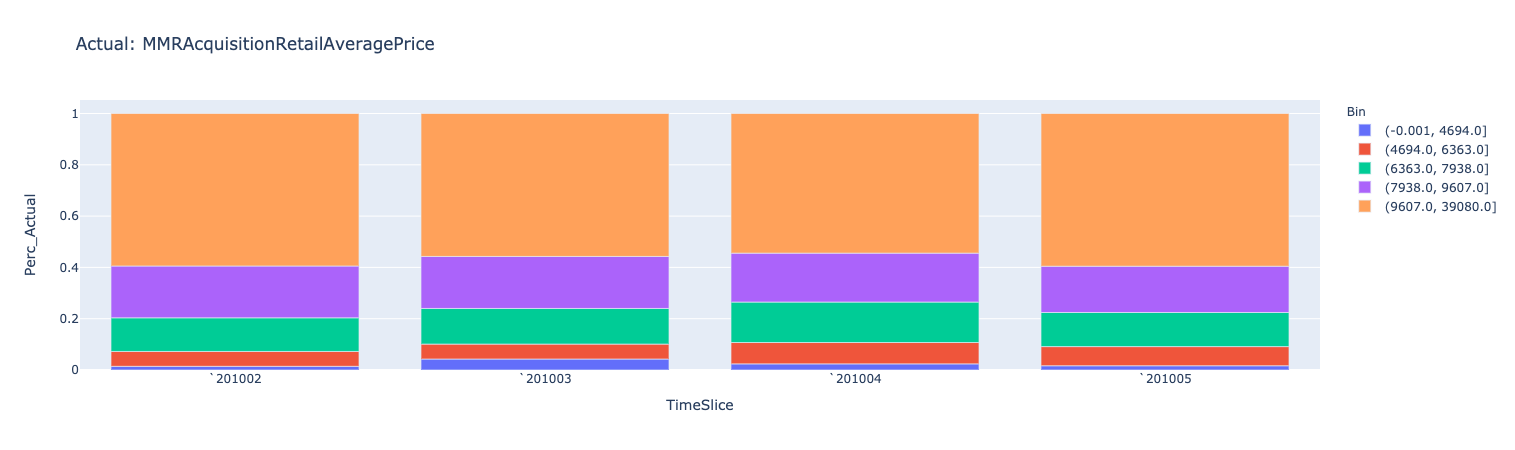

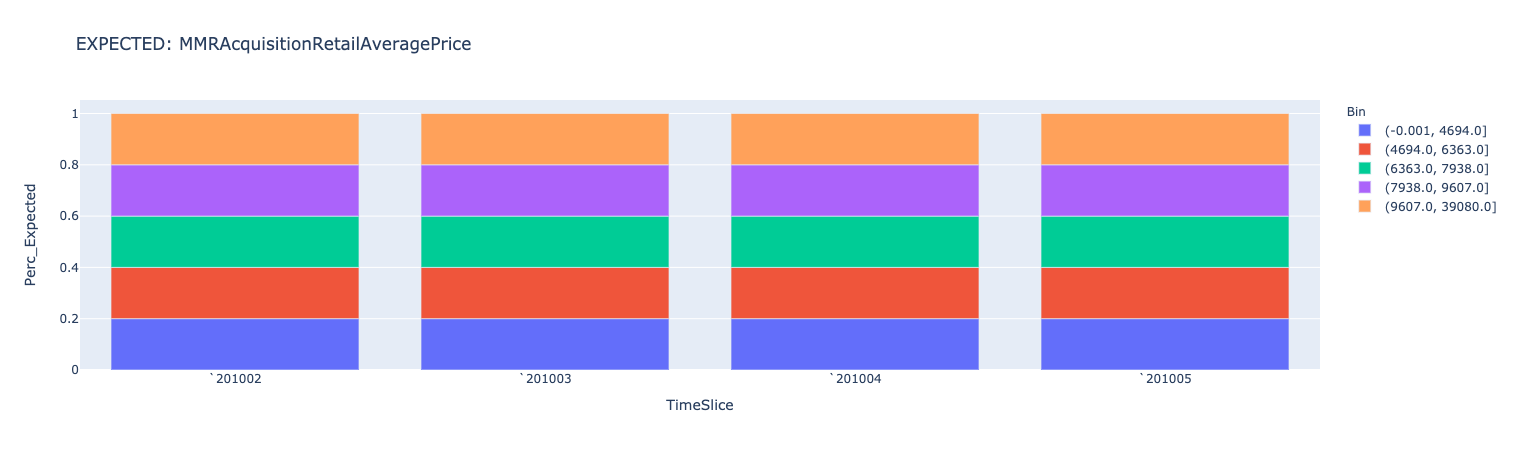

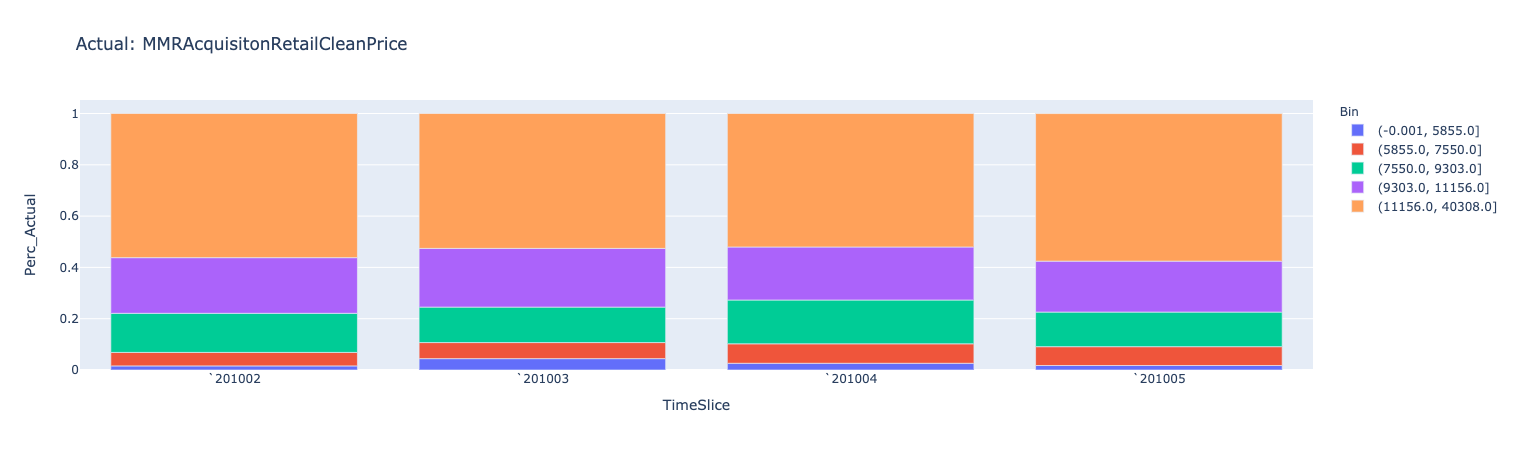

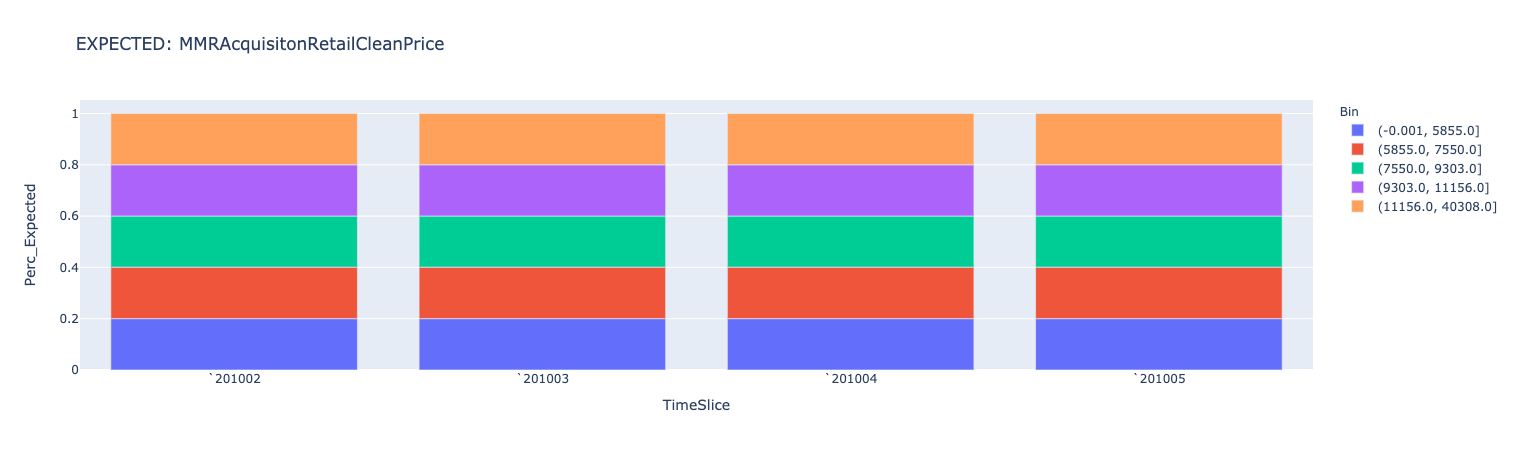

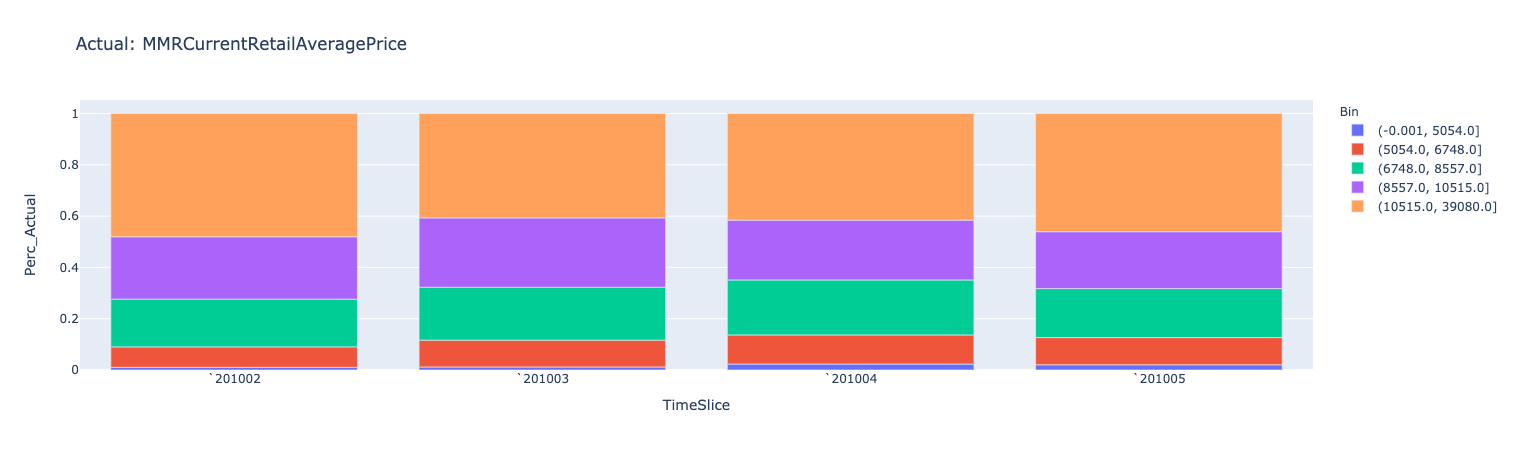

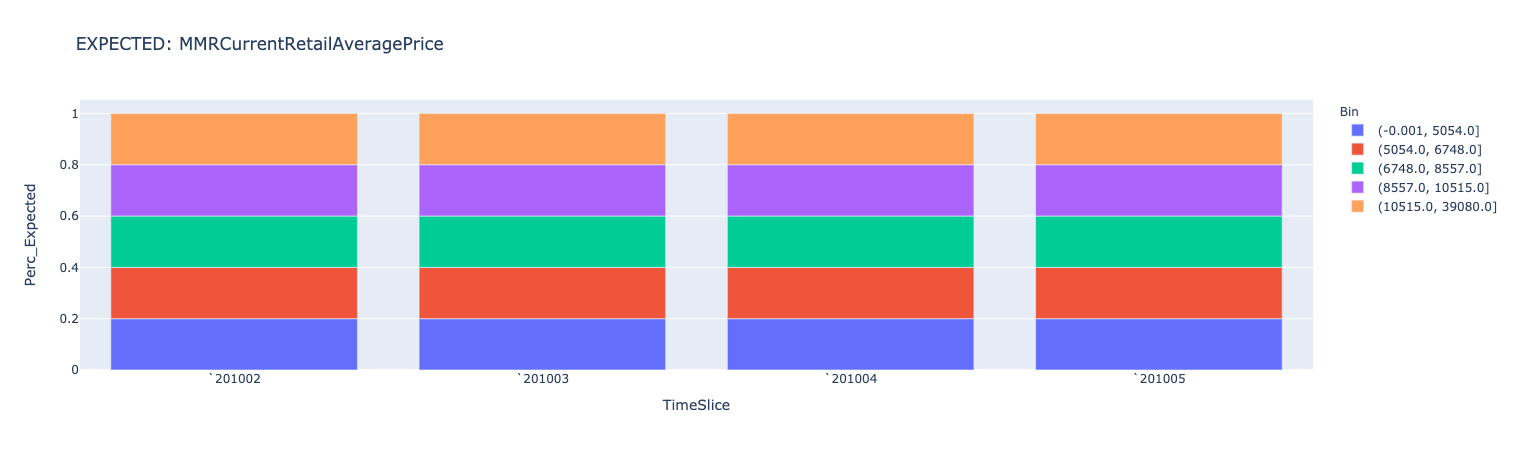

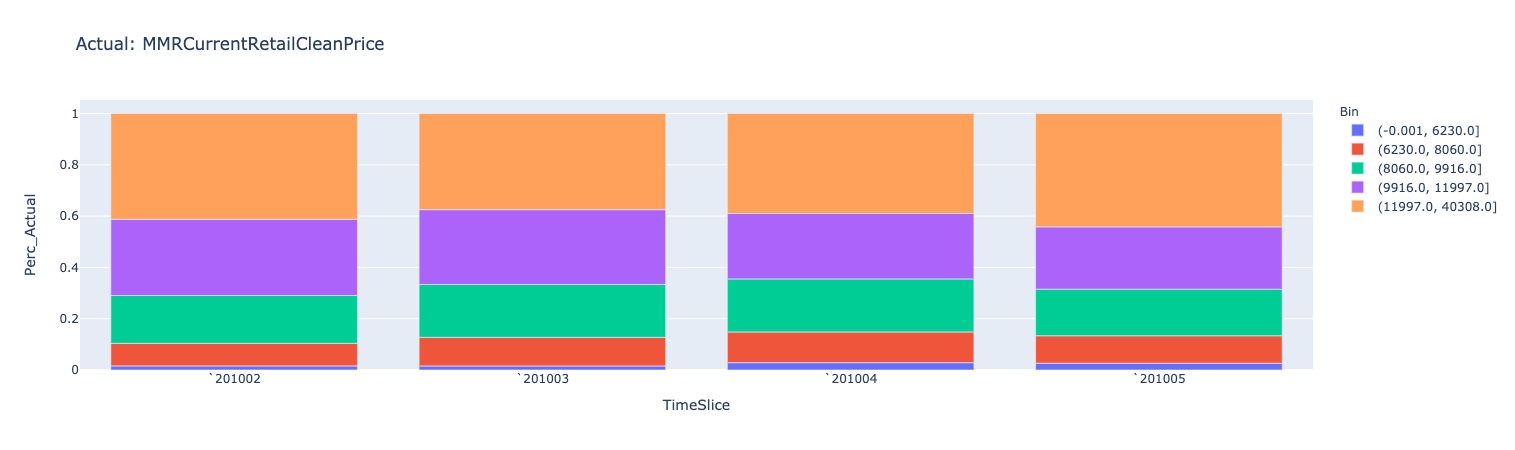

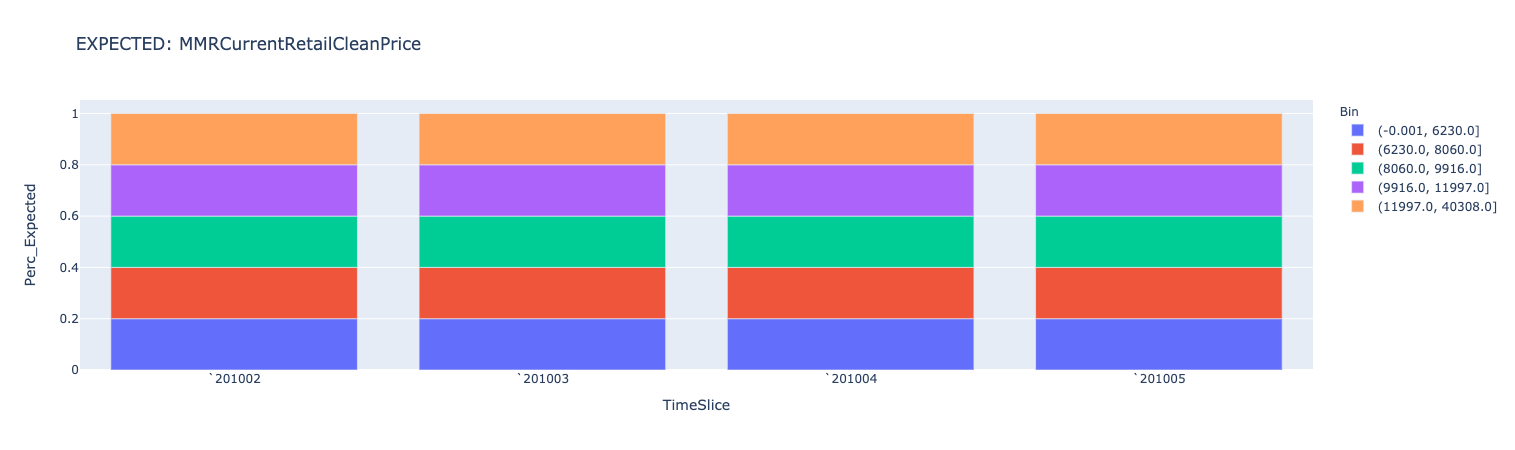

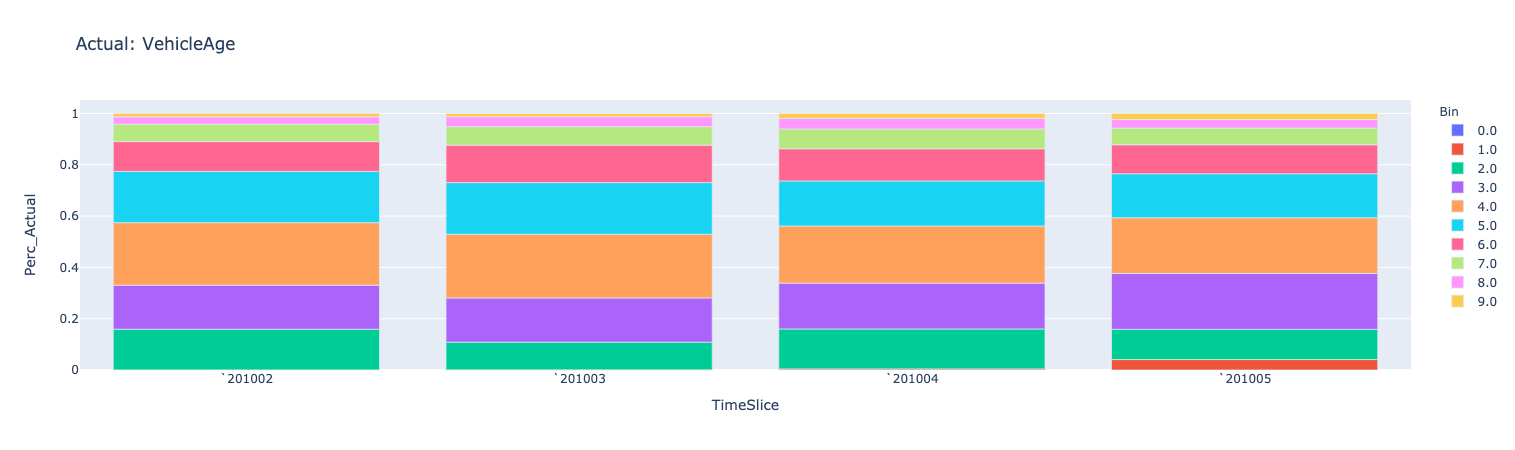

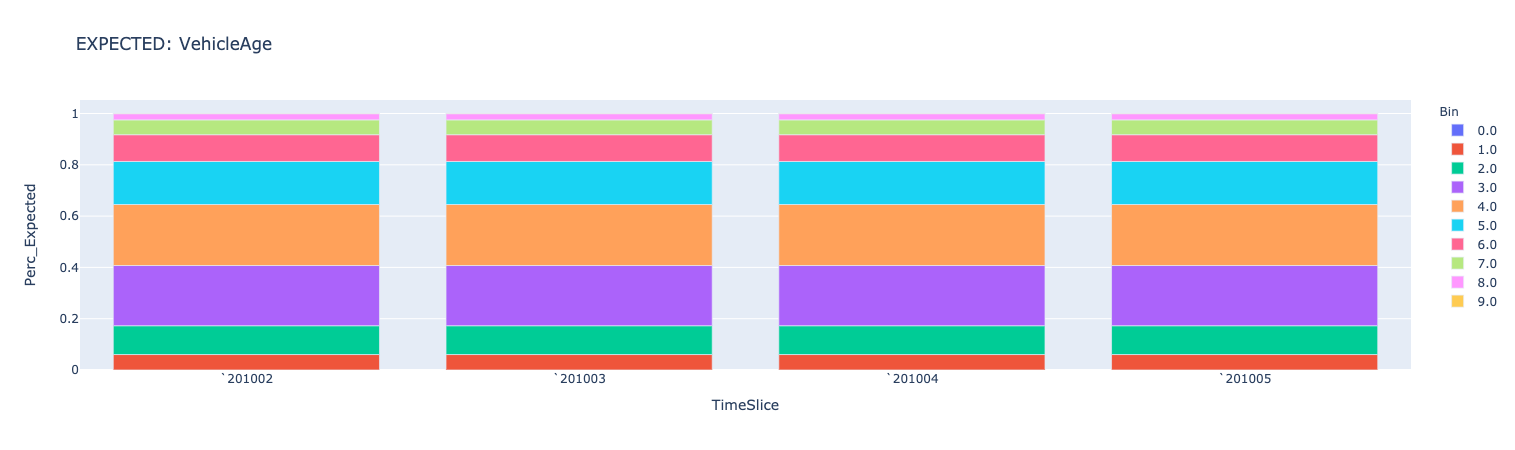

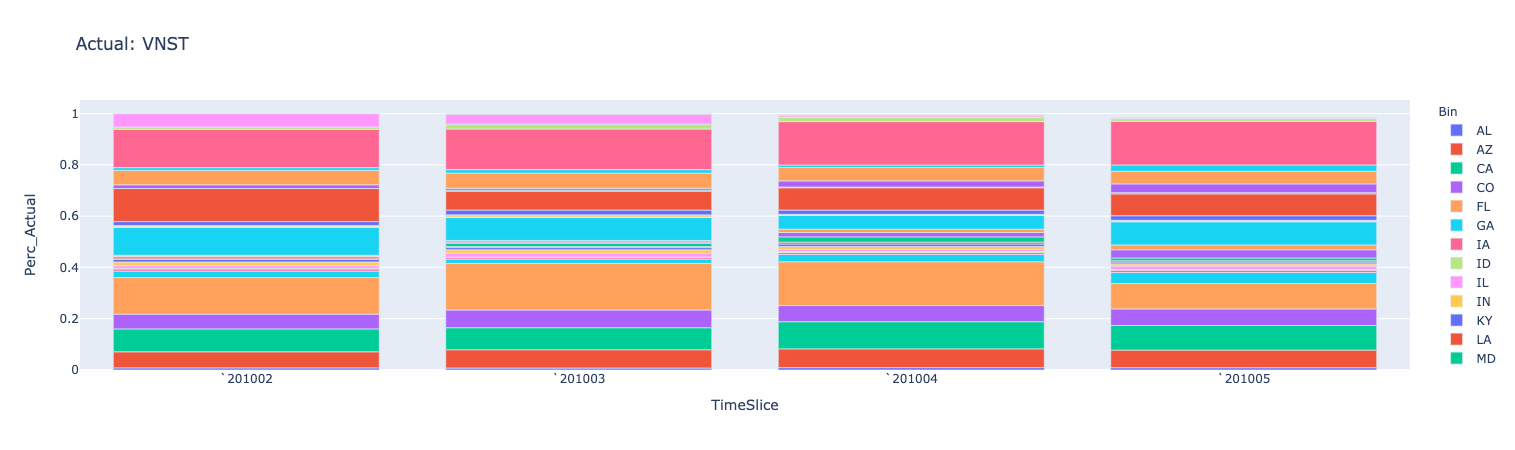

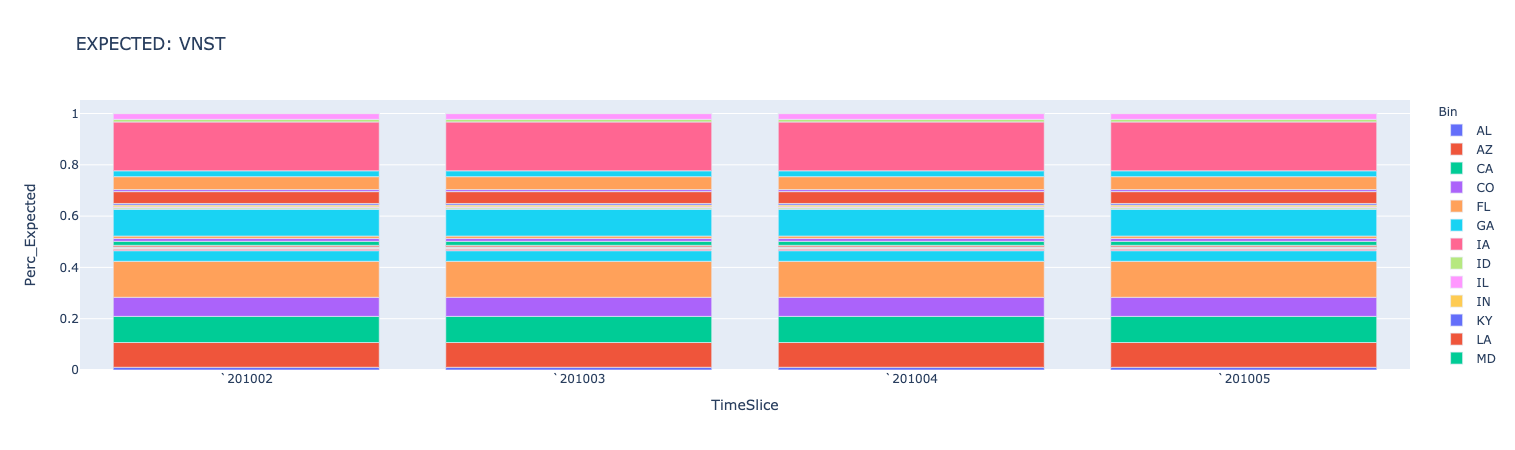

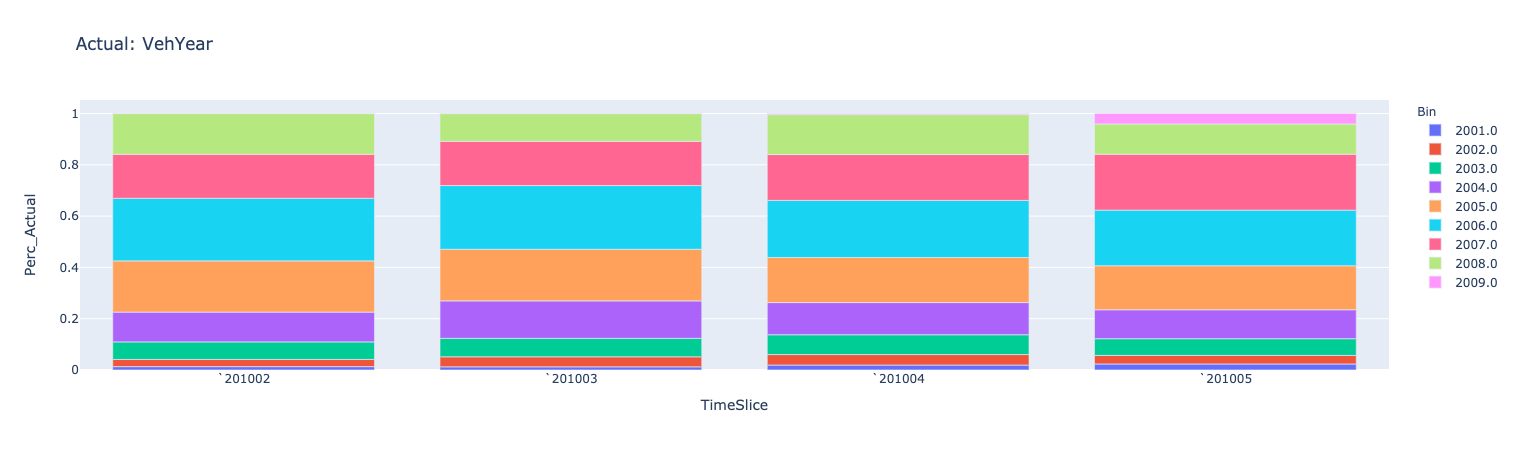

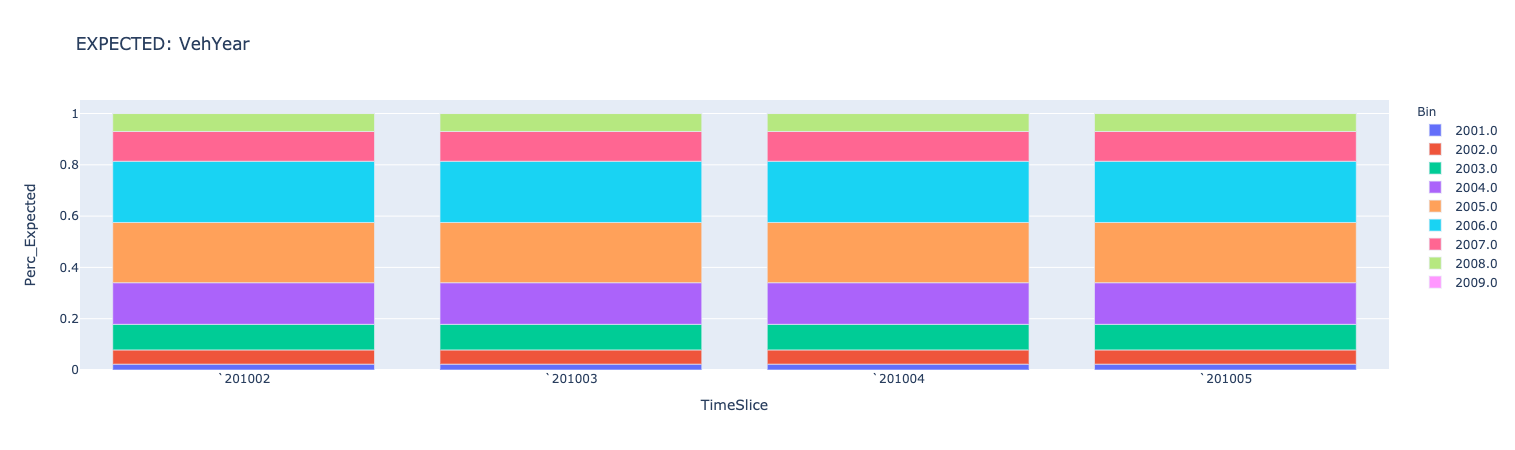

In [14]:
plot_list = pd.DataFrame(result_df[0].groupby(['Variable'])['PSI'].sum()).sort_values(by=['PSI'], axis=0, ascending=False).reset_index()['Variable'].unique().tolist()

for v in plot_list:

    try:
        try:
            del single_result
        except Exception as e:
            pass

        # keep only the var in question
        single_result = result_df[2][result_df[2]['Var'] == v].copy()
        single_result['TimeSlice'] = '`' + single_result['TimeSlice'].astype('str')

        # If the Bin is a range-string with a comma in it, extract the first bin number, to be used for ordering
        if single_result['Bin'].astype('str').str.find(',').max()>0:
            single_result['i'] = single_result['Bin'].apply(lambda x: float(str(x).split(',')[0][1:])).copy()
        else:
            single_result['i'] = single_result['Bin'].copy()

        # re-sort to correct order
        single_result.sort_values(['TimeSlice','i'], ascending=True, inplace=True)

        fig = px.bar(single_result, x="TimeSlice", y="Perc_Actual", color="Bin", title='Actual: ' + v, hover_name="Perc_Expected")
        fig.show()
        fig2 = px.bar(single_result, x="TimeSlice", y="Perc_Expected", color="Bin", title='EXPECTED: ' + v)
        fig2.show()
        print("=".join('' for a in range(100))) 
    
    except Exception as e:
        print(e)
        print("=".join('' for a in range(100))) 

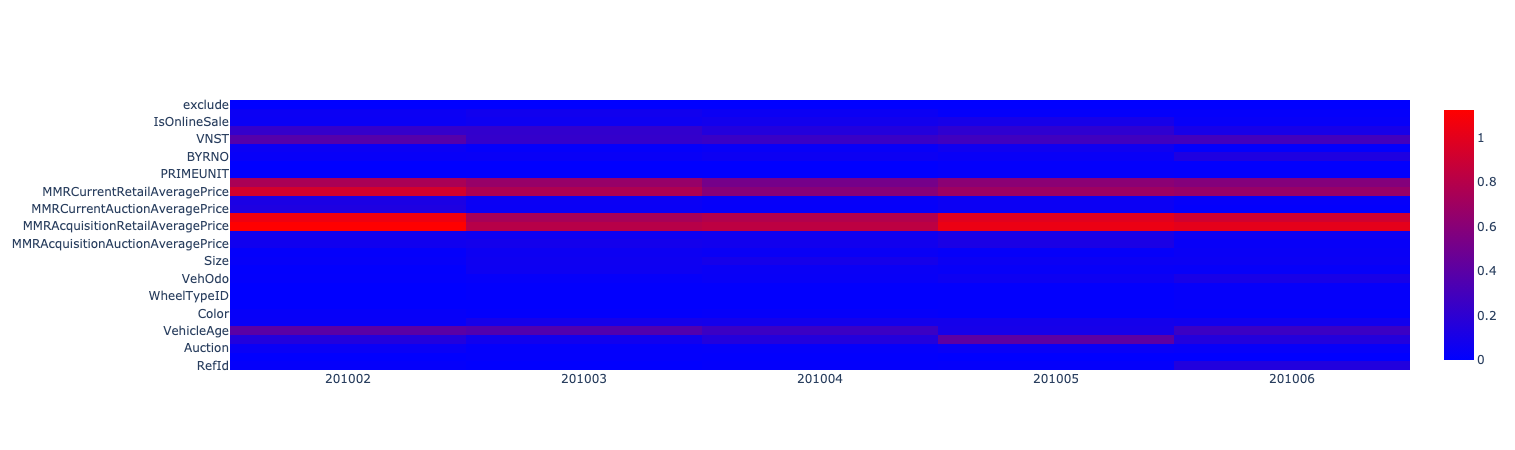

In [12]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(
        z=result_df[1]["PSI"],
        x=result_df[1]["TimeSlice"],
        y=result_df[1]["Variable"],
        colorscale='bluered'))
fig.update_xaxes(type='category')
fig.show()

In [ ]:
result_df[1]

## Plot Single Variable

In [1]:
VAR_TO_PLOT = 'Color'

try:
    del single_result
except Exception as e:
    pass

# keep only the var in question
single_result = result_df[2][result_df[2]['Var'] == VAR_TO_PLOT].copy()
single_result['Day'] = '`' + single_result['Day'].astype('str')

# If the Bin is a range-string with a comma in it, extract the first bin number, to be used for ordering
if single_result['Bin'].astype('str').str.find(',').max()>0:
    single_result['i'] = single_result['Bin'].apply(lambda x: float(str(x).split(',')[0][1:])).copy()
else:
    single_result['i'] = single_result['Bin'].copy()

# re-sort to correct order
single_result.sort_values(['Day','i'], ascending=True, inplace=True)

fig = px.bar(single_result, x="Day", y="Perc_Actual", color="Bin", title=VAR_TO_PLOT)
fig.show()

NameError: name 'result_df' is not defined